In [1]:
import pandas as pd
import numpy as np
import os
import statistics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
import sklearn.linear_model as lm
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Pulling data
Data_path = 'C:/Users/Imran/Documents/Data Science/Projects/House Prices/'
Train_df = pd.read_csv(Data_path + 'train.csv')
Test_df = pd.read_csv(Data_path + 'test.csv')

#Combining both datasets, this allows for both datasets to analyzed and manipulated together
Train_df['Dataset'] = 'Training'
Test_df['Dataset'] = 'Test'
Combined_df = Train_df.append(Test_df,sort=False)

In the dataset we have 79 different attributes, and SalePrice which is the dependant variable. The definitions of these attributes have been included in the "feature_description.txt" file (located in the same folder on Github)

Now lets start by checking for any missing data:

In [2]:
Missing = Combined_df.isnull().sum()
Missing[Missing != 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

We'll deal with the missing data by using the following rules, they've been reviewed for each attribute individually, generally I've considered if the NA just means the feature is not available (e.g. an Alley) or if the data itself is just missing:
- MZoning: Information not available, fill with the most common value.
- LotFrontage: Min is 21, Max is 313, fill with the average.
- Alley: The definitions state that "NA" means no Alley, as python interprets "NA" as blank, we will fill the blanks with "No Alley".
- Utilities: NA could mean the house has no utilities, which would mean no electricity. I think this is unlikely, so the NA is just missing data, fill with the most common value.
- Exterior1st: Not specified so we'll just fill with "Other", since this option is already available in the data.
- Exterior2nd: Not specified so we'll just fill with "Other", since this option is already available in the data.
- MasVnrType: We can't be certain if one is present, therefore we'll assume there isn't one and fill with "None"
- MasVnrArea: Following the above, we will fill with 0
- All "BSMT" features: The definitions state that "NA" for the categorical variables means no basement, as python interprets "NA" as blank, we will fill the blanks with "No Basement" for the categorical variables and 0 for the numeric variables. In addition I've noticed one entry in the test dataset where "BsmtQual" is NA but the rest of the information is present, this looks to be an error. For this notebook we'll just be covering the modeling process and not any predictions so it will be treated the same way as the rest. If we were going to be predicting using the test set then a seperate exception would be made for this.
- Electrical: Information not available, fill with the most common value.
- KitchenQual: Information not available, fill with the most common value.
- Functional: Information not available, fill with the most common value.
- FireplaceQu: The definitions state that "NA" means no Fireplace, as python interprets "NA" as blank, we will fill the blanks with "No Fireplace".
- All "Garage" features: The definitions state that "NA" for the categorical variables means no garage, as python interprets "NA" as blank, we will fill the blanks with "No Garage" for the categorical variables and 0 for the numeric variables.
- PoolQC: The definitions state that "NA" means no pool, as python interprets "NA" as blank, we will fill the blanks with "No Pool".
- Fence: The definitions state that "NA" means no fence, as python interprets "NA" as blank, we will fill the blanks with "No Fence".
- MiscFeature: The definitions state that "NA" means no miscellaneous features, as python interprets "NA" as blank, we will fill the blanks with "No features".
- SaleType: Information not available, fill with the most common value.

- This approach is quite topline and pragmatic as we are still at an early stage of the modeling process. If any of these features are deemed to be key to the model later on then we can review if the filling of blanks can be improved (although trying to model this has its own issues around the accuracy of the estimation model)

- Filling in missing values:

In [3]:
Fill_0 = ['BsmtFinSF1','BsmtFinSF2','BsmtFullBath','BsmtHalfBath','BsmtUnfSF','GarageArea','GarageCars','GarageYrBlt','MasVnrArea','TotalBsmtSF']
Combined_df[Fill_0] = Combined_df[Fill_0].fillna(0) 

Common_fill = ['Electrical','Functional','KitchenQual','MSZoning','SaleType','Utilities']
for feature in Common_fill:
    Combined_df[feature] = Combined_df[feature].fillna(statistics.mode(Combined_df[feature]))

Average_fill = ['LotFrontage']
for feature in Average_fill:
    Combined_df[feature] = Combined_df[feature].fillna(np.mean(Combined_df[feature]))

Specific_fill = {'Alley':'No Alley','BsmtCond':'No Basement','BsmtExposure':'No Basement','BsmtFinType1':'No Basement','BsmtFinType2':'No Basement','BsmtQual':'No Basement','MiscFeature':'No features','Fence':'No Fence','FireplaceQu':'No Fireplace','GarageCond':'No Garage','GarageFinish':'No Garage','GarageQual':'No Garage','GarageType':'No Garage','PoolQC':'No Pool','MasVnrType':'None','Exterior1st':'Other','Exterior2nd':'Other'}
for feature in Specific_fill:
    Combined_df[feature] = Combined_df[feature].fillna(Specific_fill[feature])

Rechecking for any missing data:

In [4]:
Missing = Combined_df.isnull().sum()
Missing[Missing != 0]

SalePrice    1459
dtype: int64

In [5]:
#Creating a copy of the dataset for later use in producing charts.
Charts_df = Combined_df[Combined_df['Dataset']=='Training'].drop(['Dataset'],axis=1)

Apply get_dummies to categorical columns, this transformation is needed before we fit our first model.

In [6]:
cols = Combined_df.columns
num_cols = Combined_df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols.remove('Dataset')
Combined_df = pd.get_dummies(Combined_df,columns=cat_cols)

Model Selection:
<br>We'll now start the process of building our model. Firstly we'll fit a model using all available features to get a baseline measure of accuracy

In [7]:
Train_df = Combined_df[Combined_df['Dataset']=='Training'].drop(['Dataset','Id'],axis=1)

X_train = Train_df.drop('SalePrice',axis=1)
Y_train = Train_df['SalePrice']

Algorithms = [lm.LinearRegression(),lm.BayesianRidge(),lm.Lasso(max_iter=5000),lm.ElasticNet(max_iter=5000),KernelRidge(),xgb.XGBRegressor()]

Scoring will be done using 5-fold cross validation, our measure of accuracy will be root mean squared error

In [8]:
def produce_scoring_grid(Algorithms,X_train,Y_train):
    Algorithm_Labels = [str(x).split('(')[0] for x in Algorithms]
    Results = []
    kf = KFold(5,shuffle = True,random_state = 42).get_n_splits(X_train.values)
    for Algo in Algorithms:
        range_score = np.sqrt(-cross_val_score(Algo,X_train.values,Y_train,scoring = 'neg_mean_squared_error',cv=kf))
        Score = round(range_score.mean(),0)
        Results.append(Score)
    Results_df = pd.DataFrame(list(zip(Algorithm_Labels,Results)),columns = ['Algorithm','Score']).sort_values('Score',ascending = True)
    Results_List = ['{:,}'.format(round(x,0)) for x in Results_df['Score']]
    Results_df['Score'] = Results_List
    return Results_df

produce_scoring_grid(Algorithms,X_train,Y_train)

,Algorithm,Score
5,XGBRegressor,"27,884.0"
1,BayesianRidge,"31,286.0"
4,KernelRidge,"32,259.0"
3,ElasticNet,"34,443.0"
2,Lasso,"34,663.0"
0,LinearRegression,"41,230,663.0"


So the best base model was the Xgboost regressor model, with a score of around 28,000, a couple of key points to explain are:
<br>**What does the 27,884 mean?**
<br>Well our scoring was root mean squared error, which breaking it down results in the following steps:
- Take the difference between the predicted and actual value
- Squaring it: this is for 2 reasons, firstly this removes the negative (to treat positive and negative errors the same), and secondly squaring larger numbers increases the value more than smaller numbers, therefore giving a increasingly worse score for more inaccruate predicitons
- Mean: a simple average to produce one score
- Root: since we squared earlier we'll now square root the final value, this is in order to return the value to the scale at which we started (so that it is comparable against the original values)
<br>So we can say our current predicitions are out by around $27,884
<br>**What is XGBoost?**
<br>XGBoost is an algorithm that starts with a simple model and then builds another model that corrects the errors of the first model, this process is repeated until accuracy cannot be improved. I've included a slide giving a basic explanation of this on GitHub

<br>Now that we've fitted our first model we've established a baseline accuracy. Let's now try and improve the model by reviewing which of the 79 features are the most useful.
<br>Create Correlation Heatmap:

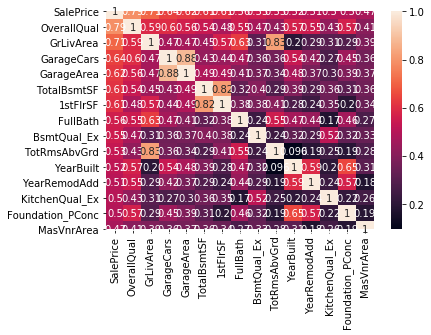

In [9]:
k = 15
corrmat = Train_df.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(Train_df[cols].values.T)
hm = sns.heatmap(cm,annot=True, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- Quality
<br>The most significant feature is Overallqual (rating of the overall material and finish of the house)
- Size:
<br>Ground floor, first floor and basement living area all have strong correlations against sales. We’ve seen strong correlations for these variables with number of rooms (more space implies more rooms are present). Basement square foot is also strongly correlated against 1st floor square foot, given that the Basement occupies the space directly underneath the house it would be expected that the size of the basement is related to floor space in the house.
Bathrooms have been included as part of this.
- Garage:
<br>Garage cars and area are among the most strongly correlated variables; both also have a strong correlation against each other
- Basement:
<br>Basement quality (in terms of higher rating) was split out using get_dummies, the highest quality shows a correlation.
- Time:
<br>We’re seeing positive correlations for year built and year remodelled, which means the new builds/ newly remodelled houses are more expensive. It’s also worth noting the poured concrete foundations do have a positive correlation against sale price but its correlation against build and remodel date is stronger, which looks like it implies that more new builds/remods have poured concrete foundations


Repeating the same analysis for negatives

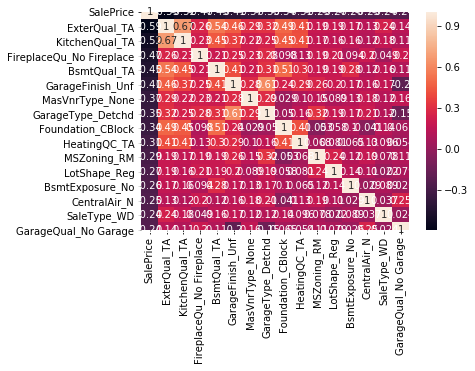

In [10]:
corrmat = Train_df.corr()
cols = list(corrmat.nsmallest(k, 'SalePrice')['SalePrice'].index)
cols.insert(0,'SalePrice')
cm = np.corrcoef(Train_df[cols].values.T)
hm = sns.heatmap(cm,annot=True, yticklabels=cols, xticklabels=cols)
plt.show()

- Quality of features
<br>The strongest negative features were low quality kitchens and low quality external, in both of these the selection was “typical/average”, it would initially be surprising that the selection of “poor” didn’t have the strongest negative correlation, however when looking through the data both the training and test datasets didn’t have the selection of “poor”, hence why we haven’t seen it.
Lack of a fireplace also had a negative impact on sales price.
- Basement
<br>As seen when analysing the positive correlations a low quality or unfinished basement has a negative correlation against sales price.


Based off this analysis the features to be investigated in more depth will be:
- OverallQual
- GrLivArea
- 1stFlrSF
- 2ndFlrSF
- GarageArea
- GarageCond
- GarageFinish
- GarageQual
- GarageType
- BsmtCond
- BsmtExposure
- BsmtFinSF1
- BsmtFinSF2
- BsmtFinType1
- BsmtFinType2
- BsmtFullBath
- BsmtHalfBath
- BsmtQual
- BsmtUnfSF
- TotalBsmtSF
- YearBuilt
- YearRemodAdd
- KitchenQual
- ExterCond
- ExterQual
- FireplaceQu
- Fireplaces

Doing the feature analysis through python isn't ideal given the number of features we have available, I'd want to be able to flick through and have multiple views available quite easily.

To help accomplish this I've created a PowerBI dashboard using this data (available on GitHub), I've done the analysis using that and have then included a few summary charts in this Jupyter notebook to present those findings.

In [11]:
def num_conv(input):
    try:
        return float(input)
    except:
        return 0

Sort_Order_Mappings = pd.read_csv(Data_path+'Sort_Order_Mappings.csv')
Sort_Order_Mappings = Sort_Order_Mappings.set_index('Attribute').squeeze()

def Chart_Scatter(Charts_df,feature):
    plt.clf()
    plt.scatter(Charts_df[feature],Charts_df['SalePrice'])
    plt.title(feature+' Against Sale Price')
    plt.xlabel(feature)
    plt.ylabel('Sale Price')
    plt.show()
    return

def Chart_Bar(Charts_df,feature):
    plt.clf()
    BarChart_df = Charts_df[[feature,'SalePrice']].groupby(feature).mean()
    BarChart_df.reset_index(inplace=True)
    BarChart_df[feature] = BarChart_df[feature].astype('str')
    BarChart_df['Sort_order'] = BarChart_df[feature].replace(Sort_Order_Mappings)
    BarChart_df['Sort_order'] = BarChart_df['Sort_order'].apply(num_conv)
    BarChart_df = BarChart_df.sort_values('Sort_order',ascending=True)
    plt.bar(BarChart_df[feature],BarChart_df['SalePrice'])
    plt.title('Average Sale Price by '+feature)
    plt.xlabel(feature)
    plt.ylabel('Average Sale Price')
    plt.show()
    return

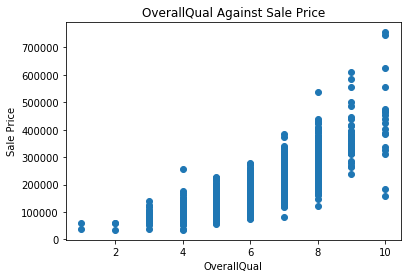

In [12]:
Chart_Scatter(Charts_df,'OverallQual')

Gradual Uplift in price as Overall Quality increases

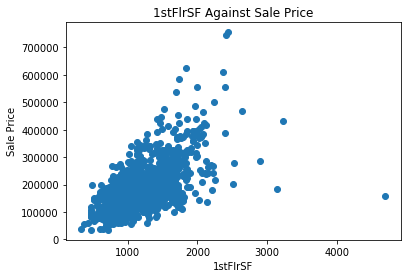

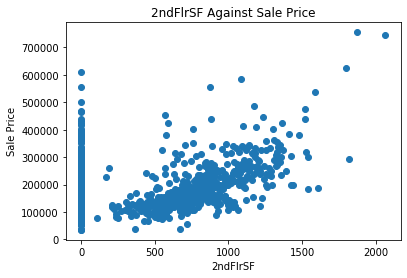

In [13]:
Chart_Scatter(Charts_df,'1stFlrSF')
Chart_Scatter(Charts_df,'2ndFlrSF')

Strong upward correlation of price against first and second floor area. Large number of 0's for 2nd floor space for houses without a second floor, ignoring those the correlation is still present

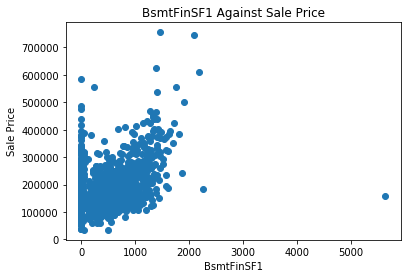

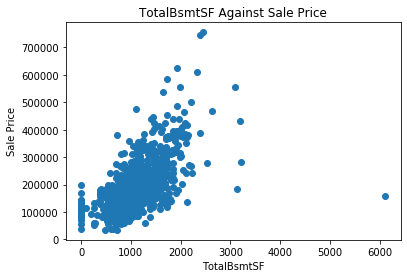

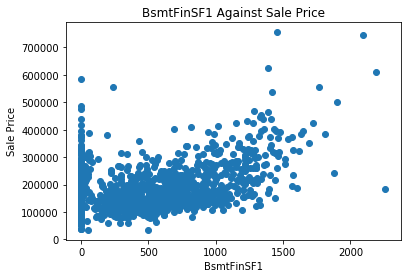

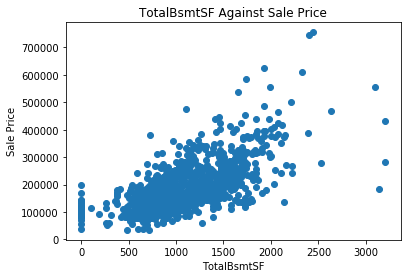

In [14]:
Chart_Scatter(Charts_df,'BsmtFinSF1')
Chart_Scatter(Charts_df,'TotalBsmtSF')
Chart_Scatter(Charts_df[Charts_df['BsmtFinSF1']<5000],'BsmtFinSF1')
Chart_Scatter(Charts_df[Charts_df['TotalBsmtSF']<5000],'TotalBsmtSF')

Looking at the top charts first, there looks to be a positive correlation of price against Basement space, however the majority of values are bunched towards the left due to the inclusion of a house with a basement size of 5,600, the next highest is 2,600. So to clean up the chart I've removed this value. The correlation is clearer now. (A range of 0 entries for houses without basements.)

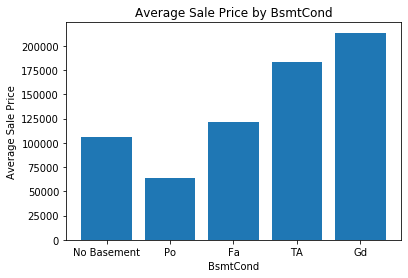

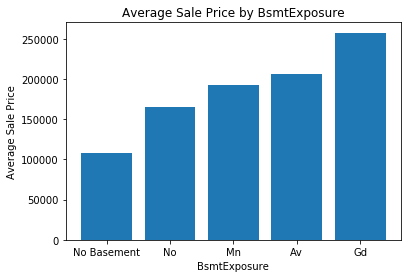

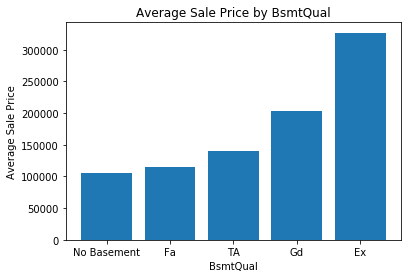

In [15]:
Chart_Bar(Charts_df,'BsmtCond')
Chart_Bar(Charts_df,'BsmtExposure')
Chart_Bar(Charts_df,'BsmtQual')

Basement condition, Exposure and quality both show a strong increase in average sale price as the rating improves

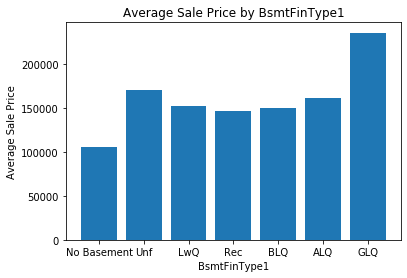

In [16]:
Chart_Bar(Charts_df,'BsmtFinType1')

Basement finish type drives an increases in sale price as the quality increases. Having an unfinished(unf) basement does seem slightly out of trend. The increase seems to be between no basement to having a basement and then a large uplift for Good Living Quarters(GLQ) 

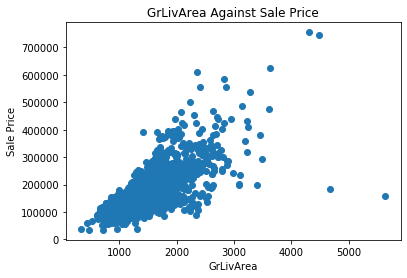

In [17]:
Chart_Scatter(Charts_df,'GrLivArea')

Ground floor living area see's a strong positive correlation against Sale Price

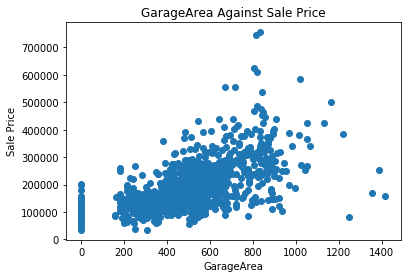

In [18]:
Chart_Scatter(Charts_df,'GarageArea')

Garage area see's a positive correlation against Sale Price, a range of 0 values for houses with no garage. This feature has a few more outliers than the rest (particularly the bottom right hand corner)

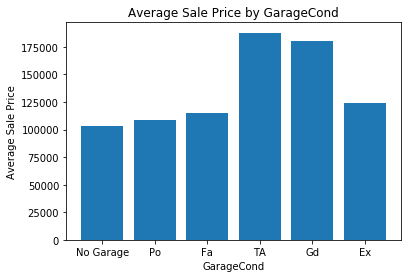

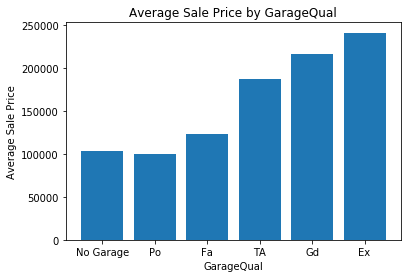

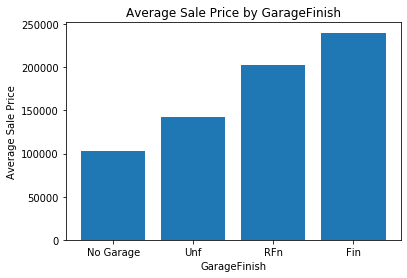

In [19]:
Chart_Bar(Charts_df,'GarageCond')
Chart_Bar(Charts_df,'GarageQual')
Chart_Bar(Charts_df,'GarageFinish')

Garage condition, quality and finish all show a strong positive correlation. Excellent condition does have an unexpected drop off but this is because there are only 2 entries for this in the entire dataset (hence more easily influenced by outliers)

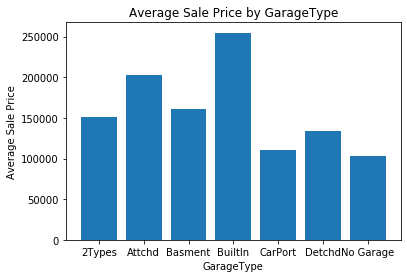

In [20]:
Chart_Bar(Charts_df,'GarageType')

Sale Price see's quite a few variations across different Garage Types.

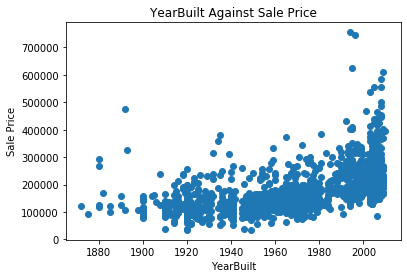

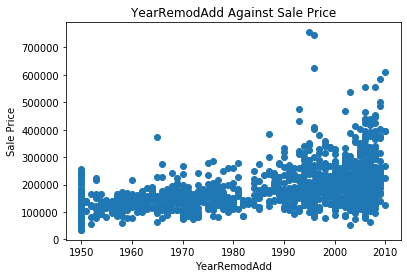

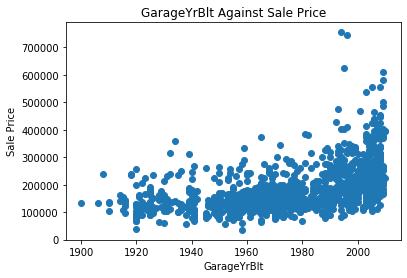

In [21]:
Chart_Scatter(Charts_df,'YearBuilt')
Chart_Scatter(Charts_df,'YearRemodAdd')
Chart_Scatter(Charts_df[Charts_df['GarageYrBlt']>0],'GarageYrBlt')

Looking at how recently the house/garage was built/modified the trend is fairly consistent beyond 10-20 years. The latest period however does show more of an uplift.

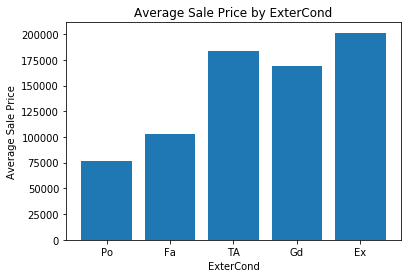

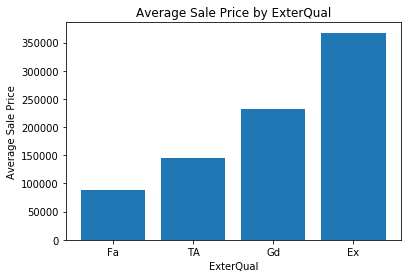

In [22]:
Chart_Bar(Charts_df,'ExterCond')
Chart_Bar(Charts_df,'ExterQual')

External Condition and Quality both drive an increase in sale price as the rating increases.

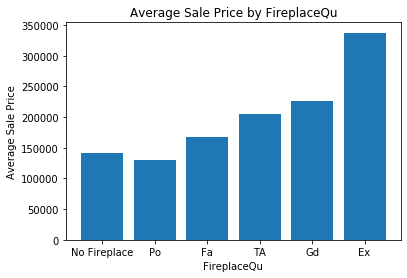

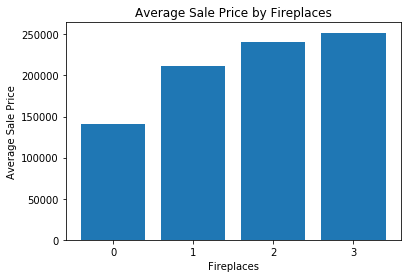

In [23]:
Chart_Bar(Charts_df,'FireplaceQu')
Chart_Bar(Charts_df,'Fireplaces')

Number and quality of fireplaces drives an increase in sale price, this looks to be one of the more key 'house feature' variables.

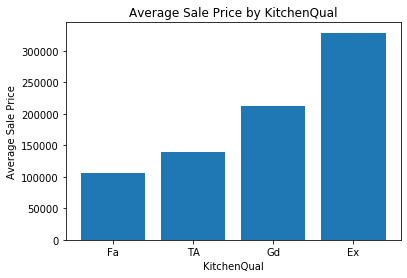

In [24]:
Chart_Bar(Charts_df,'KitchenQual')

Kitchen quality is a strong driver of sale price, similar to fireplaces, this is the other key 'house feature' variables.

**Outliers**
<br>The above charts not only allowed us to analyse the features and review correlations but also to identify any outliers, when fitting the model the outliers can introduce noise and inaccuracy to the model. Removing the entries for values with outliers may result in worse accuracy for those specific entries, but the idea is that this will improve accuracy overall.

<br>From the charts the following have been identified as outliers:
- SalesPrice above 700,000
- 1stFlrSF above 4,000
- BsmtFinSF1 above 5,000
- TotalBsmtSF above 5,000
- GrLivArea above 4,000

In [25]:
len(Train_df['SalePrice'])
Train_df = Train_df[Train_df['SalePrice']<700000]
Train_df = Train_df[Train_df['1stFlrSF']<4000]
Train_df = Train_df[Train_df['BsmtFinSF1']<5000]
Train_df = Train_df[Train_df['TotalBsmtSF']<5000]
Train_df = Train_df[Train_df['GrLivArea']<4000]
len(Train_df['SalePrice'])
X_train = Train_df.drop('SalePrice',axis=1)
Y_train = Train_df['SalePrice']

Removing these outliers has removed 4 entries from our dataset.
<br>We'll now restrict the features to those chosen from our earlier analysis and then refit our models, but before we do that I'll rerun the accuracy scores. This is because removing outliers will increase the accuracy of our model (as the outliers would most likely have had large inaccuracies in prediction), so we want to ignore that effect when seeing if our selected features do in fact improve model performance.

<br> Reruning models with outliers removed:

In [26]:
produce_scoring_grid(Algorithms,X_train,Y_train)

,Algorithm,Score
1,BayesianRidge,"23,364.0"
5,XGBRegressor,"23,555.0"
4,KernelRidge,"24,176.0"
2,Lasso,"24,700.0"
3,ElasticNet,"26,855.0"
0,LinearRegression,"40,582,263.0"


The best scores have now dropped to around 23,000. In particular Bayesian Ridge has seen the biggest improvement and is now performing similar to XGBoost

<br>Now to rerun our model with restricted features

In [27]:
Selected = ['OverallQual','1stFlrSF','2ndFlrSF','BsmtFinSF1','TotalBsmtSF','GrLivArea','GarageArea','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt','BsmtCond','BsmtExposure','BsmtFinType1','BsmtQual','YearBuilt','YearRemodAdd','ExterCond','ExterQual','FireplaceQu','Fireplaces','KitchenQual']
Final_Selected = []
for value in X_train.columns.values:
    if value.split('_')[0] in Selected:
        Final_Selected.append(value)

produce_scoring_grid(Algorithms,X_train[Final_Selected],Y_train)

,Algorithm,Score
5,XGBRegressor,"25,030.0"
1,BayesianRidge,"27,308.0"
2,Lasso,"27,375.0"
0,LinearRegression,"27,417.0"
4,KernelRidge,"27,573.0"
3,ElasticNet,"29,801.0"


Now this is interesting, selecting the most important features actually results in **worse** accuracy scores of around 25,000 - 27,000. It seems odd how selecting the most significant features (from our analysis) hasn't resulted in an improvement.
<br>The Bayesian Ridge model is simpler than XGBoost so is easier to interpret, therefore we'll now review which parameters this placed greater importance on and compare that against our selected features.

First **what is the Bayesian Ridge model?**
<br>Bayesian Ridge is very similar to the standard linear regression model (Y = B1X1 + B2X2 ...  etc.), the differences are the "Bayesian" part and the "Ridge" part, these result in the following differences:
- **Bayesian**: Instead of the output being estimated as a single value, we assume that the output follows a normal distribution and the importance of each feature is therefore selected to optimize the fit to the normal distribution.
- **Ridge**: Ridge regression applies a "ridge estimator", this is very similar to the way coefficients would be calculated in a standard linear regression model. The ridge estimator works by reducing the value of the coefficients, but does so in such a way that reduces the value of smaller coefficients more than the larger coefficients. If we think about this in terms of the data we've currently been working with, we have a lot of features, some of which may not be relevant, therefore reducing the values of smaller coefficients is pretty much like applying "automatic feature selection". Hence why we're seeing great results with this model

Next we'll see which parameters the Bayesian Ridge model gave higher/lower coefficients to (and therefore greater influence on the estimated price)

In [28]:
Model = lm.BayesianRidge()
Model.fit(X_train,Y_train)
Coef_df = pd.DataFrame({'Feature':list(X_train.columns.values),'Coefficient':list(Model.coef_)}).sort_values('Coefficient',ascending=False)
Coefficient_List = ['{:,}'.format(round(x,0)) for x in Coef_df['Coefficient']]
Coef_df['Coefficient'] = Coefficient_List
Coef_df.head(10)

,Feature,Coefficient
78,Neighborhood_StoneBr,"19,239.0"
71,Neighborhood_NoRidge,"13,588.0"
160,KitchenQual_Ex,"13,376.0"
62,Neighborhood_Crawfor,"12,602.0"
266,BsmtExposure_Gd,"12,069.0"
94,ExterQual_Ex,"11,942.0"
170,Functional_Typ,"11,564.0"
226,Exterior1st_BrkFace,"9,871.0"
72,Neighborhood_NridgHt,"9,832.0"
46,BsmtQual_Ex,"9,482.0"


In [29]:
Coef_df.tail(10)

,Feature,Coefficient
268,BsmtExposure_No,"-7,146.0"
48,BsmtQual_Gd,"-7,283.0"
97,ExterQual_TA,"-7,348.0"
181,MSZoning_C (all),"-7,472.0"
198,Condition1_RRAe,"-7,477.0"
79,Neighborhood_Timber,"-7,594.0"
126,LandSlope_Sev,"-8,094.0"
70,Neighborhood_NWAmes,"-8,190.0"
21,KitchenAbvGr,"-9,915.0"
67,Neighborhood_Mitchel,"-10,666.0"


7 of the 20 most significant features are Neighborhoods, this was a key feature that was missing from our earlier analysis as the correlation coefficients didn't show great significance (as that was just a one to one comparison against Saleprice) viewing this feature through the regression model has shown its significance.
<br> Alongside this the other significant features were those we saw earlier such as Kitchen quality and basement details. The other standout point is that the property being in a Commercial area ("MSZoning_C (all)") resulted in a lower Sale Price.

**Closing Summary and thoughts**
- Automatic feature selection through Bayesian Ridge was superior to manual feature selection through analysis
- **Location**, both in terms of Neighborhood and type of area were among the most significant features when determining price
- **Property size**, both in terms of square foot space and addtional space through basements and garage were the next strongest drivers of sale price.
- Lastly **Features** such as kitchen quality and fireplaces also had an uplift on price